In [13]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Osteoarthritis dataset/All Clinical/cleaned_data.csv')

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,P01KPNREV,P01KPNLEV,P01KPACT30,P01HPNR12,P01HPNL12,V00SF2,V00SF3,V00SF8,V00WPRKN1,V00WPRKN2,V00P7RKFR,V00KSXRKN1,V00DIRKN1,V00DIRKN2,V00DIRKN14,V00WPLKN1,V00WPLKN2,V00P7LKFR,V00KSXLKN1,V00DILKN1,V00DILKN2,V00DILKN14,V00KOOSFX5,P02KPNRCV,P02KPNLCV,P01KPR30CV,P01KPL30CV,P01KPACTCV,P01HPR12CV,P01HPL12CV,P01KPA30CV,V00P7RKRCV,V00P7LKRCV,P01PMRKRCV,P01PMLKRCV,V00WOMTSL,V00WOMTSR,P01BL12SXL,P01BL12SXR,...,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,P01RASTASV,P02KSURGCV,V00OTHCAMC,V00OTHCAM,V00DISCOMF,V00LFXCOMP,V00LFXPN,V00EKRSL,V00REXPN,V00EKRSR,V00RFXCOMP,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,V00VITDCV,V00CALCMCV,V00VIT9,V00VIT1,P01BMI,V00PASE,P01FAMKR,P02WTGA,V00RKEFFB,V00RKEFFPT,V00LKEFFB,V00LKEFFPT,V00RKRFXPN,V00LKRFXPN,V00LLWGT,V00RLWGT,cumulative_outcome
0,9000296,Yes,No,No,Yes,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,Yes,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,84.0,152.0,73.00,495.5,260.7,Didn t take,Didn t take,No,Yes,29.8,190.0,No,No,No,No,No,No,No,No,12.0,18.0,No
1,9000622,Yes,No,Yes,Yes,No,"Yes, limited a little","Yes, limited a little",Moderately,Mild,Mild,Daily,Sometimes,None,Mild,None,None,None,Never,Never,None,None,None,Moderate,Yes,No,Yes,No,Limits,Yes,No,Yes,3,No pain,2,No pain,0.0,20.9,Neither,Both IEI and SV,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,136.0,64.36,679.2,70.3,Every day,Every day,Yes,No,22.7,157.0,No,No,No,No,No,No,Yes,No,14.0,14.0,Yes
2,9001695,Yes,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Monthly,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,No,No,No,1,No pain,1,No pain,0.0,NaN,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,70.0,115.0,13.01,447.2,63.1,No vitamins/minerals taken in past year,No vitamins/minerals taken in past year,No,No,28.6,280.0,Yes,No,Yes,Yes,No,No,No,No,13.0,13.0,Yes
3,9001897,No,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,Yes,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,IEI only,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,82.0,150.0,228.89,785.9,57.7,1-3 days per week,1-3 days per week,Yes,Yes,25.9,156.0,No,No,Yes,No,No,No,No,No,16.0,17.0,Yes
4,9002411,Yes,No,No,No,No,"Yes, limited a little","Yes, limited a little",A little bit,None,Mild,Never,Never,None,Mild,None,None,None,Never,Never,None,Mild,None,None,No,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,1.1,2.1,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,110.0,29.25,551.3,164.4,Didn t take,Didn t take,No,No,31.8,54.0,No,Yes,No,No,No,No,No,No,18.0,22.0,No


In [14]:
## Replace 'No' and 'Yes' by 0 and 1 in the outcome column

df['cumulative_outcome'] = df['cumulative_outcome'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()

,ID,P01KPNREV,P01KPNLEV,P01KPACT30,P01HPNR12,P01HPNL12,V00SF2,V00SF3,V00SF8,V00WPRKN1,V00WPRKN2,V00P7RKFR,V00KSXRKN1,V00DIRKN1,V00DIRKN2,V00DIRKN14,V00WPLKN1,V00WPLKN2,V00P7LKFR,V00KSXLKN1,V00DILKN1,V00DILKN2,V00DILKN14,V00KOOSFX5,P02KPNRCV,P02KPNLCV,P01KPR30CV,P01KPL30CV,P01KPACTCV,P01HPR12CV,P01HPL12CV,P01KPA30CV,V00P7RKRCV,V00P7LKRCV,P01PMRKRCV,P01PMLKRCV,V00WOMTSL,V00WOMTSR,P01BL12SXL,P01BL12SXR,...,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,P01RASTASV,P02KSURGCV,V00OTHCAMC,V00OTHCAM,V00DISCOMF,V00LFXCOMP,V00LFXPN,V00EKRSL,V00REXPN,V00EKRSR,V00RFXCOMP,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,V00VITDCV,V00CALCMCV,V00VIT9,V00VIT1,P01BMI,V00PASE,P01FAMKR,P02WTGA,V00RKEFFB,V00RKEFFPT,V00LKEFFB,V00LKEFFPT,V00RKRFXPN,V00LKRFXPN,V00LLWGT,V00RLWGT,cumulative_outcome
0,9000296,Yes,No,No,Yes,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,Yes,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,84.0,152.0,73.00,495.5,260.7,Didn t take,Didn t take,No,Yes,29.8,190.0,No,No,No,No,No,No,No,No,12.0,18.0,0
1,9000622,Yes,No,Yes,Yes,No,"Yes, limited a little","Yes, limited a little",Moderately,Mild,Mild,Daily,Sometimes,None,Mild,None,None,None,Never,Never,None,None,None,Moderate,Yes,No,Yes,No,Limits,Yes,No,Yes,3,No pain,2,No pain,0.0,20.9,Neither,Both IEI and SV,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,136.0,64.36,679.2,70.3,Every day,Every day,Yes,No,22.7,157.0,No,No,No,No,No,No,Yes,No,14.0,14.0,1
2,9001695,Yes,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Monthly,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,No,No,No,1,No pain,1,No pain,0.0,NaN,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,70.0,115.0,13.01,447.2,63.1,No vitamins/minerals taken in past year,No vitamins/minerals taken in past year,No,No,28.6,280.0,Yes,No,Yes,Yes,No,No,No,No,13.0,13.0,1
3,9001897,No,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,Yes,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,IEI only,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,82.0,150.0,228.89,785.9,57.7,1-3 days per week,1-3 days per week,Yes,Yes,25.9,156.0,No,No,Yes,No,No,No,No,No,16.0,17.0,1
4,9002411,Yes,No,No,No,No,"Yes, limited a little","Yes, limited a little",A little bit,None,Mild,Never,Never,None,Mild,None,None,None,Never,Never,None,Mild,None,None,No,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,1.1,2.1,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,110.0,29.25,551.3,164.4,Didn t take,Didn t take,No,No,31.8,54.0,No,Yes,No,No,No,No,No,No,18.0,22.0,0


In [15]:
## Drop first column (ID of the patient)

df = df.drop('ID', axis='columns')


## Check columns to convert to dummies

columns_dummies = []

for col in df.columns:
  if df[col].dtype != 'float64' and df[col].dtype != 'int64':
    columns_dummies.append(col)

print(f'Number of columns to dummy encode = {len(columns_dummies)} out of {len(df.columns)}')


df_enc = pd.get_dummies(df, columns = columns_dummies, drop_first = True)

Number of columns to dummy encode = 103 out of 121


In [16]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702 entries, 0 to 3701
Columns: 228 entries, V00WOMTSL to V00LKRFXPN_Yes
dtypes: float64(17), int64(1), uint8(210)
memory usage: 1.2 MB


In [17]:
df_enc.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,"V00SF2_Yes, limited a little","V00SF2_Yes, limited a lot","V00SF3_Yes, limited a little","V00SF3_Yes, limited a lot",V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not at all,V00SF8_Quite a bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,"P01RASTASV_DK to RA/inflam arth, no/dk to meds",P01RASTASV_Does not report RA/inflam arth,"P01RASTASV_Report RA/inflam arth, dk to all meds","P01RASTASV_Report RA/inflam arth, no to all meds","P01RASTASV_Report RA/inflam arth, no/dk to meds",P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4-6 days per week,V00VITDCV_A few days per month,V00VITDCV_Didn t take,V00VITDCV_Every day,V00VITDCV_No vitamins/minerals taken in past year,V00CALCMCV_4-6 days per week,V00CALCMCV_A few days per month,V00CALCMCV_Didn t take,V00CALCMCV_Every day,V00CALCMCV_No vitamins/minerals taken in past year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too tender to examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too tender to examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
0,0.0,0.0,0.0,0.0,1727.2,75.0,84.1,72.7,84.0,152.0,73.00,495.5,260.7,29.8,190.0,12.0,18.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,20.9,15.0,1.0,1625.6,54.5,62.3,50.9,60.0,136.0,64.36,679.2,70.3,22.7,157.0,14.0,14.0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,NaN,0.0,0.0,1625.6,59.1,79.5,52.3,70.0,115.0,13.01,447.2,63.1,28.6,280.0,13.0,13.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,0.0,0.0,0.0,0.0,1778.0,79.5,84.1,70.5,82.0,150.0,228.89,785.9,57.7,25.9,156.0,16.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1.1,2.1,0.0,0.0,1879.6,81.8,106.8,45.5,60.0,110.0,29.25,551.3,164.4,31.8,54.0,18.0,22.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
columns_with_nan_values = []
for col in df_enc.columns:
  if df_enc[col].isnull().values.any() == True:
    columns_with_nan_values.append(col)

print(columns_with_nan_values)

['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM', 'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS', 'V00DTVITD', 'V00DTCALC', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'V00LLWGT', 'V00RLWGT']


In [19]:
for col in columns_with_nan_values:
  col_mean = df[col].describe()['mean']
  df_enc[col] = df[col].fillna(col_mean)

df_enc.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,"V00SF2_Yes, limited a little","V00SF2_Yes, limited a lot","V00SF3_Yes, limited a little","V00SF3_Yes, limited a lot",V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not at all,V00SF8_Quite a bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,"P01RASTASV_DK to RA/inflam arth, no/dk to meds",P01RASTASV_Does not report RA/inflam arth,"P01RASTASV_Report RA/inflam arth, dk to all meds","P01RASTASV_Report RA/inflam arth, no to all meds","P01RASTASV_Report RA/inflam arth, no/dk to meds",P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4-6 days per week,V00VITDCV_A few days per month,V00VITDCV_Didn t take,V00VITDCV_Every day,V00VITDCV_No vitamins/minerals taken in past year,V00CALCMCV_4-6 days per week,V00CALCMCV_A few days per month,V00CALCMCV_Didn t take,V00CALCMCV_Every day,V00CALCMCV_No vitamins/minerals taken in past year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too tender to examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too tender to examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
0,0.0,0.000000,0.0,0.0,1727.2,75.0,84.1,72.7,84.0,152.0,73.00,495.5,260.7,29.8,190.0,12.0,18.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,20.900000,15.0,1.0,1625.6,54.5,62.3,50.9,60.0,136.0,64.36,679.2,70.3,22.7,157.0,14.0,14.0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,10.076808,0.0,0.0,1625.6,59.1,79.5,52.3,70.0,115.0,13.01,447.2,63.1,28.6,280.0,13.0,13.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,0.0,0.000000,0.0,0.0,1778.0,79.5,84.1,70.5,82.0,150.0,228.89,785.9,57.7,25.9,156.0,16.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1.1,2.100000,0.0,0.0,1879.6,81.8,106.8,45.5,60.0,110.0,29.25,551.3,164.4,31.8,54.0,18.0,22.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [20]:
## Check if there are still NaN values in data frame
df_enc.isnull().values.any()

False

In [21]:
## Rename columns to have format usable with the Stats Model Formula input

print('Before = ', df_enc.columns)

# Replace all spaces and symbols by underscores

df_enc.columns = df_enc.columns.str.replace(' ', '_')
df_enc.columns = df_enc.columns.str.replace(',', '_')
df_enc.columns = df_enc.columns.str.replace(':', '_')
df_enc.columns = df_enc.columns.str.replace('/', '_')
df_enc.columns = df_enc.columns.str.replace('-', '_')

print('After = ', df_enc.columns)

Before =  Index(['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM',
       'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS',
       ...
       'P01FAMKR_Yes', 'P02WTGA_Yes', 'V00RKEFFB_Yes',
       'V00RKEFFPT_Too tender to examine', 'V00RKEFFPT_Yes', 'V00LKEFFB_Yes',
       'V00LKEFFPT_Too tender to examine', 'V00LKEFFPT_Yes', 'V00RKRFXPN_Yes',
       'V00LKRFXPN_Yes'],
      dtype='object', length=228)
After =  Index(['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM',
       'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS',
       ...
       'P01FAMKR_Yes', 'P02WTGA_Yes', 'V00RKEFFB_Yes',
       'V00RKEFFPT_Too_tender_to_examine', 'V00RKEFFPT_Yes', 'V00LKEFFB_Yes',
       'V00LKEFFPT_Too_tender_to_examine', 'V00LKEFFPT_Yes', 'V00RKRFXPN_Yes',
       'V00LKRFXPN_Yes'],
      dtype='object', length=228)


In [22]:
## Divide data set in training and testing set

df_train, df_test = train_test_split(df_enc, test_size=0.3, random_state=88)
df_train.shape, df_test.shape

((2591, 228), (1111, 228))

In [23]:
# Baseline model prediction
df_train['cumulative_outcome'].value_counts()

0    1540
1    1051
Name: cumulative_outcome, dtype: int64

In [30]:
df_train['cumulative_outcome']

558     0
2651    0
2673    0
3499    1
815     1
       ..
2964    1
362     1
2481    0
2336    0
2008    0
Name: cumulative_outcome, Length: 2591, dtype: int64

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

baseline_pred = [0]*len(df_test['cumulative_outcome'])
y_test = df_test['cumulative_outcome'].tolist()


cm_baseline = confusion_matrix(y_test, baseline_pred)
acc_baseline = accuracy_score(y_test, baseline_pred)

print(cm_baseline)
print(acc_baseline)

[[617   0]
 [494   0]]
0.5553555355535553


In [40]:
## Build formula

formula = 'cumulative_outcome ~ '

names = df_enc.columns.to_list()
names.remove('cumulative_outcome')

formula += names[0]

for name in names[1:]:
  formula += ' + ' + name


print(formula)

cumulative_outcome ~ V00WOMTSL + V00WOMTSR + P01KPACDCV + V00COMORB + V00HT25MM + V00WT25KG + V00WTMAXKG + V00WTMINKG + V00BPDIAS + V00BPSYS + V00DTVITD + V00DTCALC + V00DTCHOL + P01BMI + V00PASE + V00LLWGT + V00RLWGT + P01KPNREV_Yes + P01KPNLEV_Yes + P01KPACT30_Yes + P01HPNR12_Yes + P01HPNL12_Yes + V00SF2_Yes__limited_a_little + V00SF2_Yes__limited_a_lot + V00SF3_Yes__limited_a_little + V00SF3_Yes__limited_a_lot + V00SF8_Extremely + V00SF8_Moderately + V00SF8_Not_at_all + V00SF8_Quite_a_bit + V00WPRKN1_Mild + V00WPRKN1_Moderate + V00WPRKN1_None + V00WPRKN1_Severe + V00WPRKN2_Mild + V00WPRKN2_Moderate + V00WPRKN2_None + V00WPRKN2_Severe + V00P7RKFR_Daily + V00P7RKFR_Monthly + V00P7RKFR_Never + V00P7RKFR_Weekly + V00KSXRKN1_Never + V00KSXRKN1_Often + V00KSXRKN1_Rarely + V00KSXRKN1_Sometimes + V00DIRKN1_Mild + V00DIRKN1_Moderate + V00DIRKN1_None + V00DIRKN1_Severe + V00DIRKN2_Mild + V00DIRKN2_Moderate + V00DIRKN2_None + V00DIRKN2_Severe + V00DIRKN14_Mild + V00DIRKN14_Moderate + V00DIRKN1

In [41]:
## Logistic Regression Model from Stats Model Formula 

logreg = smf.logit(formula = formula, data = df_train).fit()
print(logreg.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: ignored

In [ ]:
y_prob = logreg.predict(df_test)
y_pred = pd.Series([1 if x > 0.5 else 0 for x in y_prob], index=y_prob.index)
print(y_pred)

144     0
2937    0
1732    1
1038    1
2080    0
       ..
190     1
1559    0
2468    0
2940    0
1294    0
Length: 1111, dtype: int64


In [ ]:
## Confusion matrix and accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_test = df_test['cumulative_outcome']

cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))

Confusion Matrix : 
 [[510 107]
 [246 248]]
Accuracy: 0.6823


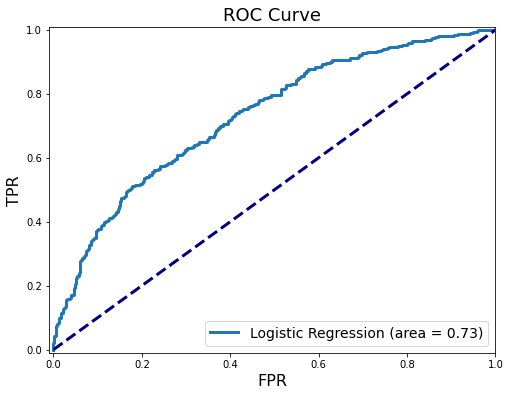

In [ ]:
## ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [ ]:
## Find optmal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(optimal_threshold)

0.4972765894859267


In [ ]:
## Recompute confusion matrix and accuracy with optimal threshold

y_pred_opt = pd.Series([1 if x > 0.4972765894859267 else 0 for x in y_prob], index=y_prob.index)

cm_opt = confusion_matrix(y_test, y_pred_opt)

print ("Confusion Matrix : \n", cm) 
print("Accuracy:", round(accuracy_score(y_test, y_pred_opt),4))

Confusion Matrix : 
 [[510 107]
 [246 248]]
Accuracy: 0.6832
